

---


# Section 1 - load imports and mount drive

---

In [ ]:
# 1 - load imports and mount drive


from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, random_split
import time
import os
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score
from collections import Counter
from copy import deepcopy


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---


# Section 2 - Load paths to data locations

---

In [ ]:
# 2 - Load paths to data locations


train_dir = Path('/content/drive/MyDrive/apple dataset/train')
test_dir = Path('/content/drive/MyDrive/apple dataset/test')



---


# Section 3 - Present data of sellable and not sellable labels

---

Found 5138 images in /content/drive/MyDrive/MSC/Neural Networks/Final Exercise/apple dataset/train/sellable


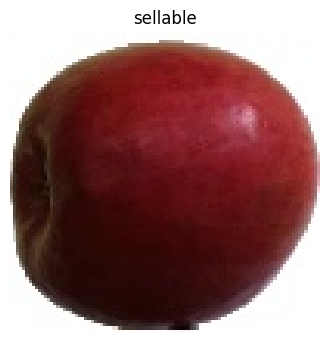

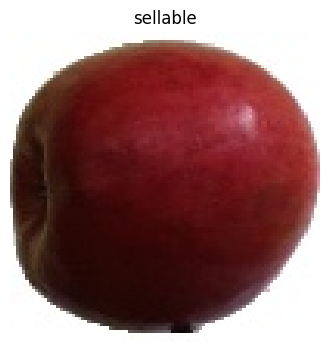

Found 9932 images in /content/drive/MyDrive/MSC/Neural Networks/Final Exercise/apple dataset/train/not_sellable


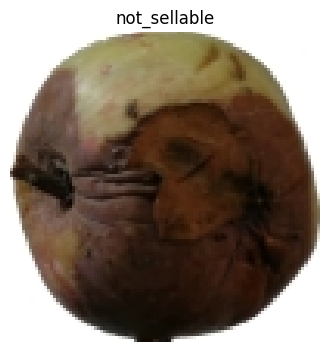

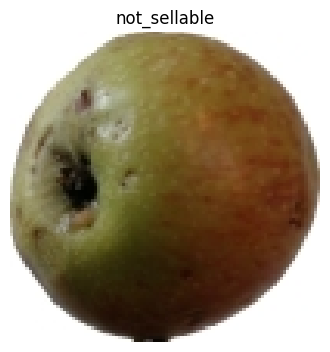

In [ ]:
# 3 - Present data of sellable and not sellable labels


train_sellable_dir = train_dir / 'sellable'
train_not_sellable_dir =  train_dir / 'not_sellable'

def show_image(image_path, title='Image'):
    image = Image.open(image_path)
    plt.figure(figsize=(4, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_images_from_folder(folder_path, max_images=2):
    # Get the folder name (sellable or not_sellable) for title
    folder_name = os.path.basename(folder_path)

    # Filter image files
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    print(f'Found {len(image_files)} images in {folder_path}')

    for img_name in image_files[:max_images]:
        img_path = os.path.join(folder_path, img_name)
        show_image(img_path, title=folder_name)

show_images_from_folder(train_sellable_dir)
show_images_from_folder(train_not_sellable_dir)



---


# Section 4 - Data Preparation

---

In [ ]:
# 4 - Data preparation


# -------------------- 1. Set device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------- 2. Define transforms --------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------- 3. Load base dataset safely --------------------
base_dataset = datasets.ImageFolder(train_dir)

# Split indices
train_val_split = 0.8
num_total = len(base_dataset)
indices = np.random.permutation(num_total)
train_size = int(train_val_split * num_total)
train_indices = indices[:train_size]
val_indices   = indices[train_size:]

# Apply transform dynamically
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

# Final datasets
train_dataset = TransformedSubset(Subset(base_dataset, train_indices), train_transform)
val_dataset   = TransformedSubset(Subset(base_dataset, val_indices), test_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transform)

# -------------------- 4. DataLoaders --------------------
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# -------------------- 5. Info --------------------
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))
print("Classes:", base_dataset.classes)

# For training set class distribution (use base_dataset before split)
train_labels = [label for _, label in base_dataset.imgs]
train_counts = Counter([train_labels[i] for i in train_indices])
print("\nTraining set class distribution:")
for idx, count in train_counts.items():
    print(f"  Class '{base_dataset.classes[idx]}': {count} images")

# For test set
test_labels = [label for _, label in test_dataset.imgs]
test_counts = Counter(test_labels)
print("Test set class distribution:")
for idx, count in test_counts.items():
    print(f"  Class '{test_dataset.classes[idx]}': {count} images")

Using device: cuda
Number of training samples: 12056
Number of validation samples: 3014
Number of test samples: 5030
Classes: ['not_sellable', 'sellable']

Training set class distribution:
  Class 'sellable': 4107 images
  Class 'not_sellable': 7949 images
Test set class distribution:
  Class 'not_sellable': 3315 images
  Class 'sellable': 1715 images




---


# Section 5 - Model Number 1 - Training

Model Number 1
  Model and training parameters:
  - Using pretrained VGG16 model with frozen convolutional layers (feature extractor)
  - Modified final classifier layer to output 2 classes (sellable, not sellable)
  - Loss function: CrossEntropyLoss for multi-class classification
  - Optimizer: Adam, only updating the classifier parameters, learning rate = 1e-4, weight_decay=1e-5
  - Training for 2 epochs
  - Using GPU if available, else CPU
  - During training, printing loss and accuracy per epoch
  - Saving best model based on highest test accuracy

---

In [ ]:
# 5 - Model Number 1 (Binary Classification)

# 6. Load pretrained VGG16 and modify for binary classification
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# ✅ Output only 1 logit for binary classification
model.classifier[6] = nn.Linear(4096, 1)  # 1 output unit for binary
model = model.to(device)

# 7. Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4, weight_decay=1e-4)

# 8. Training loop
num_epochs = 2
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs = inputs.to(device)

        # If labels come as one-hot [1, 0] or [0, 1], convert to single value
        if labels.dim() > 1 and labels.size(1) > 1:
            labels = labels.argmax(dim=1)  # Convert one-hot to class indices

        # Convert to float and reshape for BCEWithLogitsLoss
        labels = labels.float().unsqueeze(1).to(device)  # shape [B, 1]

        optimizer.zero_grad()
        outputs = model(inputs)  # shape [B, 1]
        loss = criterion(outputs, labels)  # BCEWithLogitsLoss expects logits + float labels

        loss.backward()
        optimizer.step()

        # ✅ Compute predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()  # shape [B, 1]
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)
    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Evaluation
    model.eval()
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs = inputs.to(device)

            if labels.dim() > 1 and labels.size(1) > 1:
                labels = labels.argmax(dim=1)  # Convert one-hot to class indices

            labels = labels.float().unsqueeze(1).to(device)  # shape [B, 1]

            outputs = model(inputs)  # shape [B, 1]
            preds = (torch.sigmoid(outputs) > 0.5).float()  # threshold at 0.5
            val_corrects += (preds == labels).sum().item()

    val_acc = val_corrects / len(val_dataset)  # Changed from test_dataset to val_dataset
    print(f"           Validation Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vgg16_model_number_1.pth")
        print("Best model saved!")

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")

In [ ]:
# 6 - Model number 1: Check the model weights file location


# Check where the model is saved
!ls -l best_vgg16_model_number_1.pth

-rw-r--r-- 1 root root 537070846 Jul 30 18:26 best_vgg16_model_number_1.pth


In [ ]:
# 7 - Model number 1: Create folder and copy model file there


!mkdir -p "/content/drive/MyDrive/Models"
!cp best_vgg16_model_number_1.pth "/content/drive/MyDrive/Models/"



---


### Section 5 - Model number 1 : Load model, preprocess images, predict and display random test samples with labels

---

Using device: cuda


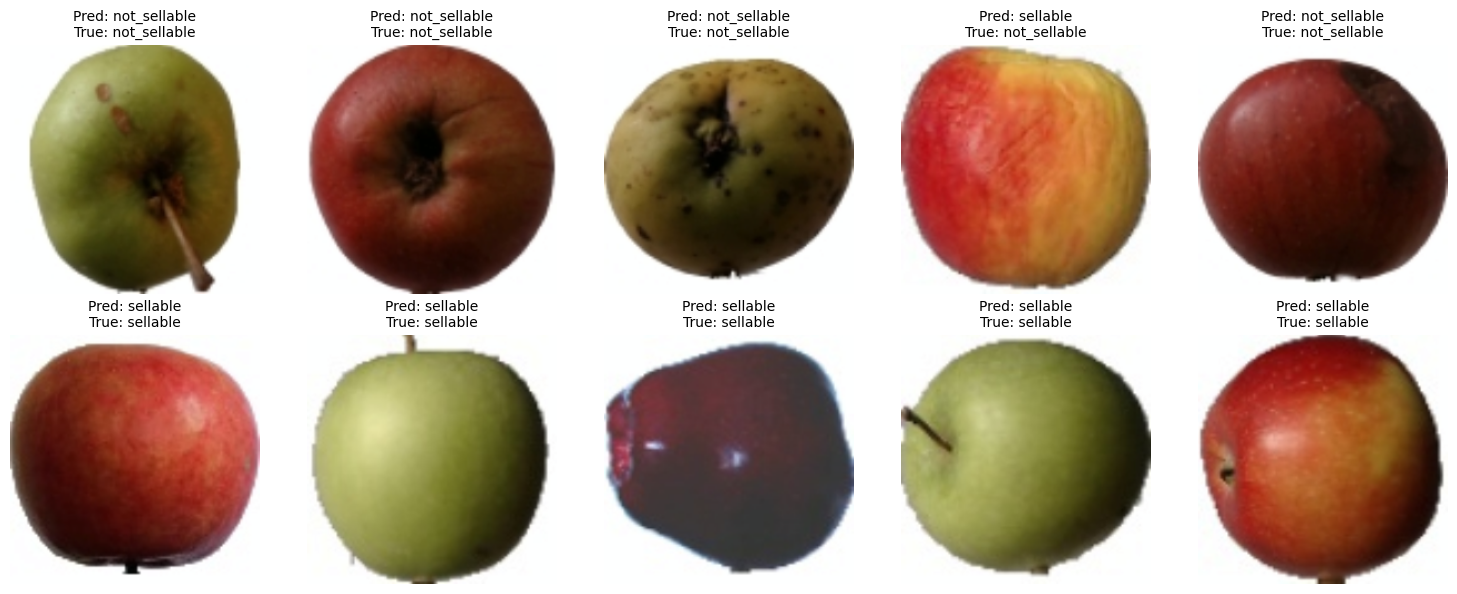

In [ ]:
# 8 - Model number 1: Load model, preprocess images, predict and display random test samples with labels


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model and weights
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/best_vgg16_model_number_1.pth'))
model = model.to(device)
model.eval()

# Transformation (same as test)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to unnormalize and show image
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def get_random_images_from_class(class_name, max_images=5):
    folder_path = os.path.join(test_dir, class_name)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    chosen = random.sample(image_files, min(len(image_files), max_images))
    images = []
    for fname in chosen:
        path = os.path.join(folder_path, fname)
        img = Image.open(path).convert('RGB')
        images.append((img, path))
    return images

class_names = ['not_sellable', 'sellable']
image_pairs = []
for cls in class_names:
    imgs = get_random_images_from_class(cls)
    image_pairs.extend([(img, cls) for img, _ in imgs])

plt.figure(figsize=(15, 6))
for i, (img, true_label) in enumerate(image_pairs):
    input_tensor = transform(img).unsqueeze(0).to(device)
    output = model(input_tensor)
    _, pred = torch.max(output, 1)
    pred_label = class_names[pred.item()]

    plt.subplot(2, 5, i + 1)
    imshow(transform(img))
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)

plt.tight_layout()
plt.show()




---


# Section 6 - Model Number 2 - Training

  Model and training parameters:
  - Pretrained VGG16 model with frozen convolutional layers (feature extractor)
  - Modified final fully connected layer to output 2 classes
  - Loss function: CrossEntropyLoss for classification
  - Optimizer: Adam, updating only classifier parameters, learning rate = 1e-4
  - Training for up to 30 epochs with Early Stopping (patience = 3 epochs)
  - Early stopping monitors test accuracy; training stops if no improvement for 3 consecutive epochs
  - Model saved whenever test accuracy improves
  - Uses GPU if available (device)
---

In [ ]:
# 9 - Model Number 2


# --- Configs ---
THRESHOLD = 0.7
num_epochs = 30
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model Setup ---
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = True  # Fine-tune all layers

model.classifier[6] = nn.Linear(4096, 1)  # Binary classification output
model = model.to(device)

# --- Loss and Optimizer ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# --- Early Stopping ---
best_precision = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs = inputs.to(device)

        if labels.dim() > 1 and labels.size(1) > 1:
            labels = labels.argmax(dim=1)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}")

    # --- Validation ---
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs = inputs.to(device)

            if labels.dim() > 1 and labels.size(1) > 1:
                labels = labels.argmax(dim=1)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > THRESHOLD).float()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    val_precision = precision_score(all_labels, all_preds)
    print(f"           Validation Precision: {val_precision:.4f}")

    # --- Early Stopping Check ---
    if val_precision > best_precision:
        best_precision = val_precision
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_vgg16_model_number_2.pth")
        print("Best model saved!")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print(f"Training complete. Best validation precision: {best_precision:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30 - Training: 100%|██████████| 377/377 [03:30<00:00,  1.79it/s]


[1/30] Train Loss: 0.2921


Epoch 1/30 - Validation: 100%|██████████| 95/95 [00:16<00:00,  5.80it/s]


           Validation Precision: 0.9595
Best model saved!


Epoch 2/30 - Training: 100%|██████████| 377/377 [02:58<00:00,  2.11it/s]


[2/30] Train Loss: 0.1933


Epoch 2/30 - Validation: 100%|██████████| 95/95 [00:16<00:00,  5.62it/s]


           Validation Precision: 0.9760
Best model saved!


Epoch 3/30 - Training: 100%|██████████| 377/377 [02:59<00:00,  2.11it/s]


[3/30] Train Loss: 0.1635


Epoch 3/30 - Validation: 100%|██████████| 95/95 [00:16<00:00,  5.70it/s]


           Validation Precision: 1.0000
Best model saved!


Epoch 4/30 - Training: 100%|██████████| 377/377 [02:59<00:00,  2.10it/s]


[4/30] Train Loss: 0.1486


Epoch 4/30 - Validation: 100%|██████████| 95/95 [00:17<00:00,  5.37it/s]


           Validation Precision: 1.0000
No improvement for 1 epoch(s).


Epoch 5/30 - Training: 100%|██████████| 377/377 [02:59<00:00,  2.10it/s]


[5/30] Train Loss: 0.1343


Epoch 5/30 - Validation: 100%|██████████| 95/95 [00:18<00:00,  5.08it/s]


           Validation Precision: 1.0000
No improvement for 2 epoch(s).


Epoch 6/30 - Training: 100%|██████████| 377/377 [02:59<00:00,  2.11it/s]


[6/30] Train Loss: 0.1281


Epoch 6/30 - Validation: 100%|██████████| 95/95 [00:16<00:00,  5.66it/s]


           Validation Precision: 0.9969
No improvement for 3 epoch(s).


Epoch 7/30 - Training: 100%|██████████| 377/377 [02:59<00:00,  2.11it/s]


[7/30] Train Loss: 0.1190


Epoch 7/30 - Validation: 100%|██████████| 95/95 [00:16<00:00,  5.73it/s]


           Validation Precision: 0.9989
No improvement for 4 epoch(s).


Epoch 8/30 - Training: 100%|██████████| 377/377 [02:59<00:00,  2.10it/s]


[8/30] Train Loss: 0.1130


Epoch 8/30 - Validation: 100%|██████████| 95/95 [00:16<00:00,  5.73it/s]

           Validation Precision: 0.9950
No improvement for 5 epoch(s).
Early stopping triggered after 8 epochs.
Training complete. Best validation precision: 1.0000


In [ ]:
# 10 - Model number 2: Check the model weights file location


# Check where the model is saved
!ls -l best_vgg16_model_number_2.pth

-rw-r--r-- 1 root root 537070846 Aug  4 19:05 best_vgg16_model_number_2.pth


In [ ]:
# 11 - Model number 2: Create folder and copy model file there


!mkdir -p "/content/drive/MyDrive/Models"
!cp best_vgg16_model_number_2.pth "/content/drive/MyDrive/Models/"



---


### Section 6 - Model number 2 : Load model, preprocess images, predict and display random test samples with labels

---

Using device: cuda


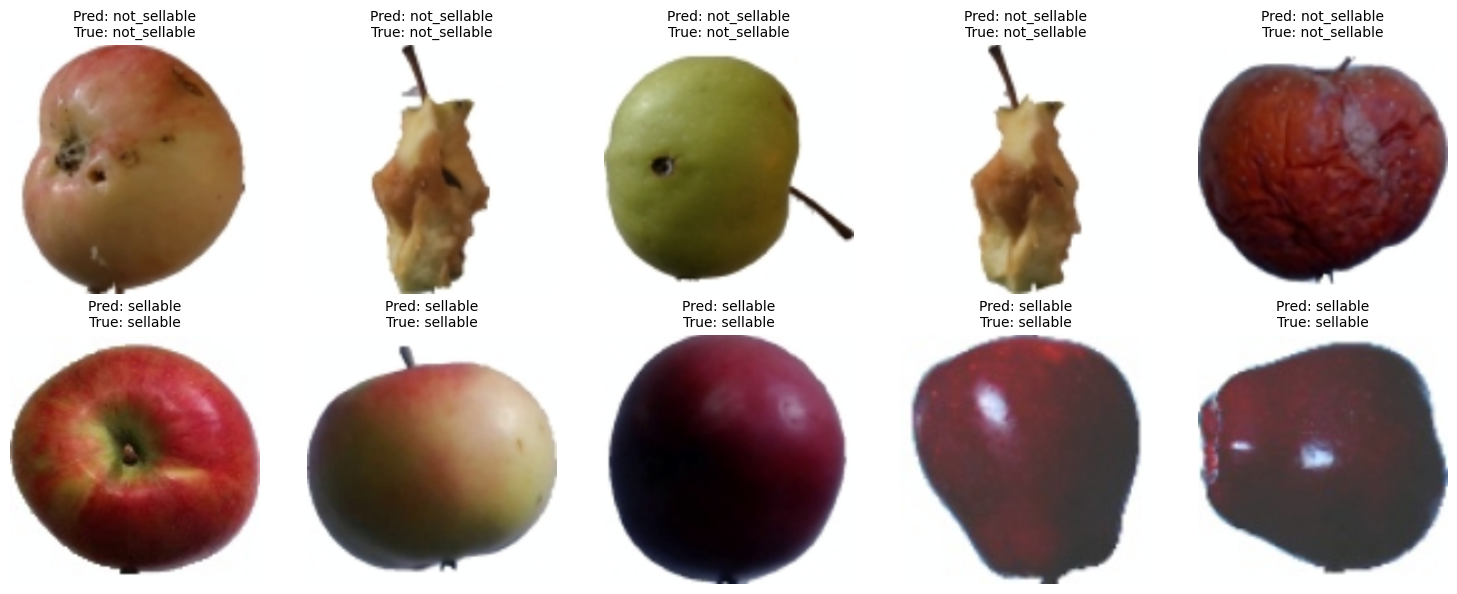

In [ ]:
# 12 - Model number 2: Load model, preprocess images, predict and display random test samples with labels


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model and weights
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/best_vgg16_model_number_2.pth'))
model = model.to(device)
model.eval()

# Transformation (same as test)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to unnormalize and show image
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def get_random_images_from_class(class_name, max_images=5):
    folder_path = os.path.join(test_dir, class_name)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    chosen = random.sample(image_files, min(len(image_files), max_images))
    images = []
    for fname in chosen:
        path = os.path.join(folder_path, fname)
        img = Image.open(path).convert('RGB')
        images.append((img, path))
    return images

class_names = ['not_sellable', 'sellable']
image_pairs = []
for cls in class_names:
    imgs = get_random_images_from_class(cls)
    image_pairs.extend([(img, cls) for img, _ in imgs])

plt.figure(figsize=(15, 6))
for i, (img, true_label) in enumerate(image_pairs):
    input_tensor = transform(img).unsqueeze(0).to(device)
    output = model(input_tensor)
    _, pred = torch.max(output, 1)
    pred_label = class_names[pred.item()]

    plt.subplot(2, 5, i + 1)
    imshow(transform(img))
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)

plt.tight_layout()
plt.show()


---------------------------------------------------------------------
# Section 7 - Model Number 3 : MobileNet

This section trains a pretrained MobileNetV2 model for binary classification.
  - Pretrained on ImageNet (weights='IMAGENET1K_V1')
  - Final classifier layer is replaced with a single output (1 neuron)
  - Loss function: BCEWithLogitsLoss, with class_weights (to handle imbalance)
  - Optimizer: Adam, learning rate = 1e-4
  - Trains for 3 epochs using provided train_loader and val_loader
  - Best model weights are saved to disk as 'MobileNetV2_best.pth'
---------------------------------------------------------------------

In [ ]:
# Section 13 - Model: MobileNetV2



# === CONFIG ===
EPOCHS = 30
PATIENCE = 3
LEARNING_RATE = 1e-4
THRESHOLD = 0.7  # Custom threshold to improve precision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("\n Training MobileNetV2 with Early Stopping (Precision-based)...")

# Load and modify pretrained MobileNetV2
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_precision = 0
best_model_state = deepcopy(model.state_dict())
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(outputs) > THRESHOLD).float()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = running_corrects / total_train
    print(f"[{epoch+1}/{EPOCHS}] Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    # === Validation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > THRESHOLD).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_precision = precision_score(all_labels, all_preds, zero_division=0)
    print(f"           Validation Precision: {val_precision:.4f}")

    # === Check for improvement
    if val_precision > best_val_precision:
        best_val_precision = val_precision
        best_model_state = deepcopy(model.state_dict())
        patience_counter = 0
        print("             Validation precision improved — model saved.")
    else:
        patience_counter += 1
        print(f"             No improvement. Patience counter: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("             Early stopping triggered.")
        break

# Save best model
torch.save(best_model_state, "MobileNetV2_best_mode_number_3.pth")
print(f"\n Best validation precision: {best_val_precision:.4f}")
print("Saved best MobileNetV2 model to 'MobileNetV2_best_mode_number_3.pth'")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



 Training MobileNetV2 with Early Stopping (Precision-based)...


100%|██████████| 13.6M/13.6M [00:00<00:00, 119MB/s]
Epoch 1/30 - Training: 100%|██████████| 377/377 [01:40<00:00,  3.76it/s]


[1/30] Train Loss: 0.1487 | Acc: 0.9297


Epoch 1/30 - Validation: 100%|██████████| 95/95 [00:12<00:00,  7.31it/s]


           Validation Precision: 0.9990
             Validation precision improved — model saved.


Epoch 2/30 - Training: 100%|██████████| 377/377 [01:27<00:00,  4.33it/s]


[2/30] Train Loss: 0.0663 | Acc: 0.9724


Epoch 2/30 - Validation: 100%|██████████| 95/95 [00:14<00:00,  6.57it/s]


           Validation Precision: 0.9970
             No improvement. Patience counter: 1/3


Epoch 3/30 - Training: 100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


[3/30] Train Loss: 0.0475 | Acc: 0.9801


Epoch 3/30 - Validation: 100%|██████████| 95/95 [00:13<00:00,  7.29it/s]


           Validation Precision: 1.0000
             Validation precision improved — model saved.


Epoch 4/30 - Training: 100%|██████████| 377/377 [01:28<00:00,  4.25it/s]


[4/30] Train Loss: 0.0455 | Acc: 0.9826


Epoch 4/30 - Validation: 100%|██████████| 95/95 [00:14<00:00,  6.52it/s]


           Validation Precision: 1.0000
             No improvement. Patience counter: 1/3


Epoch 5/30 - Training: 100%|██████████| 377/377 [01:27<00:00,  4.31it/s]


[5/30] Train Loss: 0.0357 | Acc: 0.9852


Epoch 5/30 - Validation: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


           Validation Precision: 1.0000
             No improvement. Patience counter: 2/3


Epoch 6/30 - Training: 100%|██████████| 377/377 [01:28<00:00,  4.28it/s]


[6/30] Train Loss: 0.0316 | Acc: 0.9874


Epoch 6/30 - Validation: 100%|██████████| 95/95 [00:13<00:00,  6.82it/s]

           Validation Precision: 1.0000
             No improvement. Patience counter: 3/3
             Early stopping triggered.

 Best validation precision: 1.0000
Saved best MobileNetV2 model to 'MobileNetV2_best_mode_number_3.pth'


In [ ]:
# 14 - Model number 3: Check the model weights file location


# Check where the model is saved
!ls -l MobileNetV2_best_mode_number_3.pth

-rw-r--r-- 1 root root 9152272 Aug  4 19:32 MobileNetV2_best_mode_number_3.pth


In [ ]:
# 15 - Model number 3: Create folder and copy model file there


!mkdir -p "/content/drive/MyDrive/Models"
!cp MobileNetV2_best_mode_number_3.pth "/content/drive/MyDrive/Models/"



---


# Section 8 - Models Testing Section

---

Using device: cuda

--- Evaluating: Model 1 (VGG16) ---
Test size: 5030

--- Classification Report ---
              precision    recall  f1-score   support

not_sellable     0.9834    0.9813    0.9823      3315
    sellable     0.9640    0.9679    0.9660      1715

    accuracy                         0.9767      5030
   macro avg     0.9737    0.9746    0.9741      5030
weighted avg     0.9768    0.9767    0.9768      5030


--- Accuracy ---
Accuracy: 0.9767


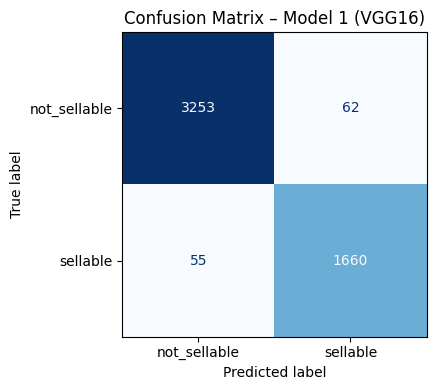

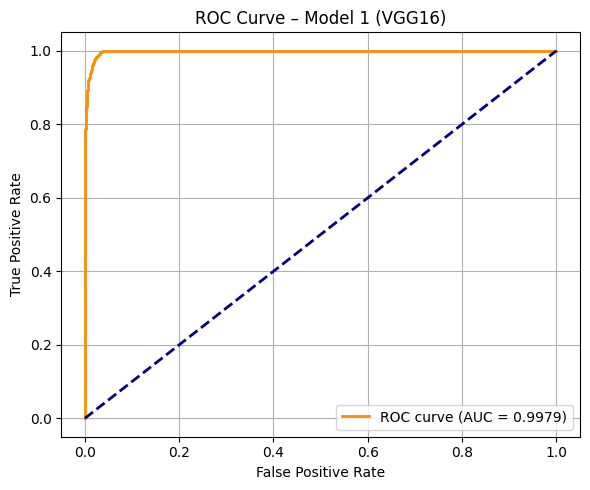


--- Evaluating: Model 2 (VGG16 - with early stopping) ---
Test size: 5030

--- Classification Report ---
              precision    recall  f1-score   support

not_sellable     0.9460    0.9988    0.9717      3315
    sellable     0.9974    0.8898    0.9405      1715

    accuracy                         0.9616      5030
   macro avg     0.9717    0.9443    0.9561      5030
weighted avg     0.9635    0.9616    0.9611      5030


--- Accuracy ---
Accuracy: 0.9616


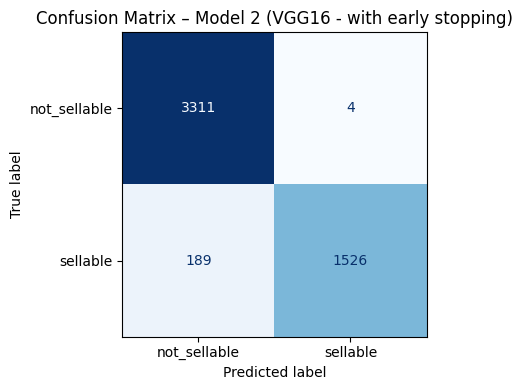

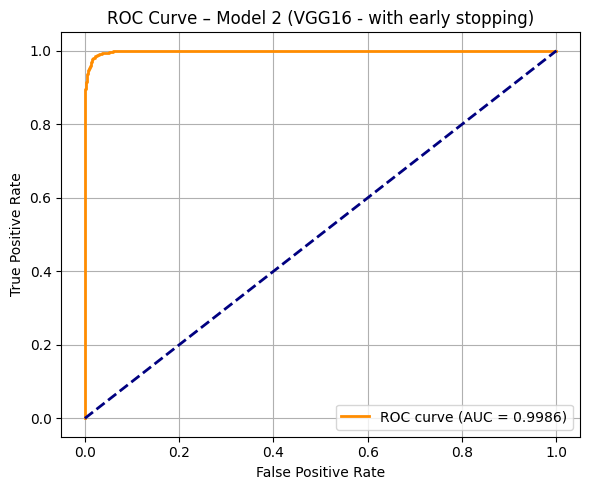


--- Evaluating: Model 3 (MobileNetV2) ---
Test size: 5030

--- Classification Report ---
              precision    recall  f1-score   support

not_sellable     1.0000    0.9961    0.9980      3315
    sellable     0.9925    1.0000    0.9962      1715

    accuracy                         0.9974      5030
   macro avg     0.9962    0.9980    0.9971      5030
weighted avg     0.9974    0.9974    0.9974      5030


--- Accuracy ---
Accuracy: 0.9974


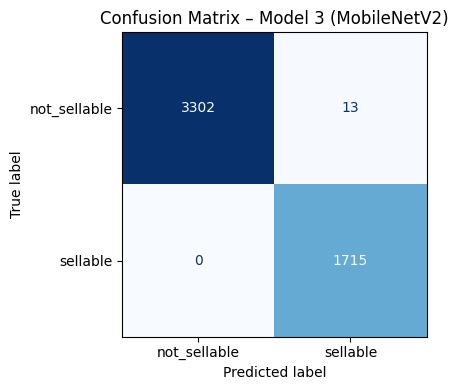

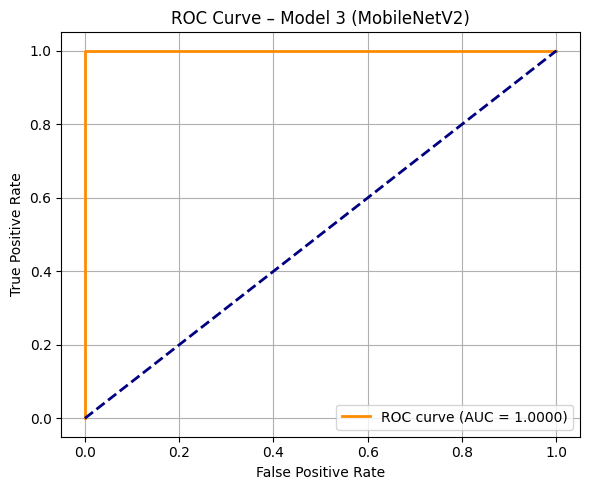

(0.9974155069582505, np.float64(0.9999982410546636))

In [ ]:
# 16 - Model number 1 and Model number 2: Load model, test, and show metrics


def evaluate_model(model_path, model_name, test_loader, class_names, device, model_type='vgg16'):
    print(f"\n--- Evaluating: {model_name} ---")

    # Load model with binary classification architecture
    if model_type == 'vgg16':
        model = models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(4096, 1)  # Binary: 1 output
    elif model_type == 'mobilenet':
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(1280, 1)  # Binary: 1 output

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Inference
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        print(f"Test size: {len(test_loader.dataset)}")
        for inputs, labels in test_loader:
            inputs = inputs.to(device)

            # Handle label format
            if labels.dim() > 1 and labels.size(1) > 1:
                labels = labels.argmax(dim=1)  # Convert one-hot to class indices

            labels = labels.to(device)
            outputs = model(inputs)

            # Binary classification - always use sigmoid
            probs_pos = torch.sigmoid(outputs).squeeze()  # Probability of positive class
            preds = (probs_pos > 0.5).long()  # Convert to class predictions

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs_pos.cpu().numpy())  # Probability of class 1

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    # Metrics
    print("\n--- Classification Report ---")
    print(classification_report(all_targets, all_preds,
                                target_names=class_names,
                                digits=4))

    print("\n--- Accuracy ---")
    print(f"Accuracy: {accuracy_score(all_targets, all_preds):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title(f"Confusion Matrix – {model_name}")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve – {model_name}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

    return accuracy_score(all_targets, all_preds), roc_auc


# --- Call the function for both models ----------------------------------------
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class_names = ['not_sellable', 'sellable']

# Evaluate VGG16 models (binary classification)
evaluate_model('/content/drive/MyDrive/Models/best_vgg16_model_number_1.pth',
               model_name='Model 1 (VGG16)',
               test_loader=test_loader,
               class_names=class_names,
               device=device,
               model_type='vgg16')

# Note: Update the path if your Model 2 was saved with the binary version
evaluate_model('/content/drive/MyDrive/Models/best_vgg16_model_number_2.pth',  # Updated filename
               model_name='Model 2 (VGG16 - with early stopping)',
               test_loader=test_loader,
               class_names=class_names,
               device=device,
               model_type='vgg16')

# For MobileNetV2 (binary classification)
evaluate_model('/content/drive/MyDrive/Models/MobileNetV2_best_mode_number_3.pth',
               model_name='Model 3 (MobileNetV2)',
               test_loader=test_loader,
               class_names=class_names,
               device=device,
               model_type='mobilenet')